In [6]:
import pandas as pd
from ebmdatalab import bq
from upsetplot import plot

## What's the overall record population?

In [4]:
qry = """
select 
    True as vmp, 
    case when ddd.vpid is not null then True else False end as present_in_ddd_table, 
    case when ddd.DDD is not null then True else False end as with_ddd, 
    case when ddd.ATC is not null then True else False end as with_atc, 
    case when ddd.BNF is not null then True else False end as with_bnf_in_ddd

from `ebmdatalab.dmd.vmp` vmp
left join `ebmdatalab.dmd.ddd` ddd  on ddd.vpid = vmp.id
"""

df_bool = bq.cached_read(csv_path='ddd_boolean.csv',sql=qry)

Downloading: 100%|██████████| 22319/22319 [00:01<00:00, 20913.53rows/s]


{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fee325e9b50>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fee32670e20>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fee326701f0>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fee324d2220>}

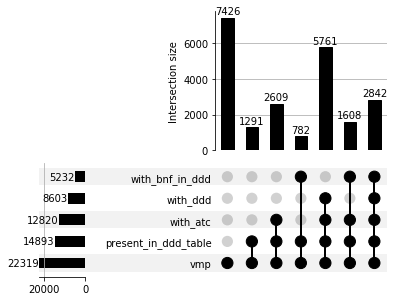

In [19]:
plot(df_bool.groupby(['vmp','present_in_ddd_table','with_ddd','with_atc','with_bnf_in_ddd']).size(), show_counts=True)

## How many ATC-route combinations have incomplete DDD records?

DDD is defined by WHO at ATC + route of administration level.

Some VMPs in NHSD-provided DDD table have NULL DDDs wheras other products with the same ATC and route of administration have populated DDDs.

What is the extent of this problem?

In [43]:
qry = """
with cte as (
    select
        vmp.id as vmpid,
        ddd.ATC, 
        r.descr as route, 
        case when ddd.DDD is not null then True else False end as with_ddd, 
        case when ddd.BNF is not null then True else False end as with_bnf_in_ddd
    from `ebmdatalab.dmd.vmp` vmp
    join `ebmdatalab.dmd.ddd` ddd  on ddd.vpid = vmp.id
    join `ebmdatalab.dmd.droute` dr on vmp.id = dr.vmp
    join `ebmdatalab.dmd.route` r on dr.route = r.cd
    where ddd.ATC is not null )
,cte2 as (
    select 
        atc,
        route,
        count(distinct with_ddd) count_ddd,
        max(with_ddd) max_ddd,
        count(distinct with_bnf_in_ddd) count_bnf,
        max(with_bnf_in_ddd) max_bnf,
        count(distinct vmpid) as vmps
    from cte
    group by atc,route
)
select 
    atc,
    route,
    case when count_ddd=1 and max_ddd = True then 'full' when count_ddd>1 then 'partial' else 'none' end as ddd,
    case when count_bnf=1 and max_bnf = True then 'full' when count_bnf>1 then 'partial' else 'none' end as bnf,
    vmps
from cte2 
"""
df_atcroute = bq.cached_read(csv_path='ddd_atcroute.csv',sql=qry)

Downloading: 100%|██████████| 3065/3065 [00:00<00:00, 13453.31rows/s]


In [52]:
df_atcroute.describe(include='all')

,atc,route,ddd,bnf,vmps
count,3065,3065,3065,3065,3065.000000
unique,2175,62,3,3,NaN
top,N01BB52,Oral,full,full,NaN
freq,12,1211,1481,1105,NaN
mean,NaN,NaN,NaN,NaN,4.573246
std,NaN,NaN,NaN,NaN,9.127931
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,NaN,4.000000


In [41]:
pd.pivot_table(df_atcroute.groupby(['ddd','bnf']).size().reset_index(),values=0,index='ddd',columns='bnf',aggfunc='sum',margins=True)

bnf,full,none,partial,All
ddd,,,,
full,576,338,567,1481
none,522,638,288,1448
partial,7,24,105,136
All,1105,1000,960,3065


How many VMPs for each ATC-route class described above?

In [47]:
#df_atcroute.groupby(['ddd','bnf']).sum()
pd.pivot_table(df_atcroute.groupby(['ddd','bnf']).sum().reset_index(),values='vmps',index='ddd',columns='bnf',aggfunc='sum',margins=True)

bnf,full,none,partial,All
ddd,,,,
full,1147,783,6430,8360
none,932,1550,1856,4338
partial,24,116,1179,1319
All,2103,2449,9465,14017
